# Tercer modelo

Support Vector Regression utilizando como predictores los datos propios del Índice IBEX 35 y los 10 componentes más importantes que pertenecen a este índice (AENA, AMS, BBVA, CABK, FER, IBE, ITX, REP, SAN, TEF). Este índice integra las cotizaciones de las 35 empresas más importantes de España. Es un índice ponderado según la capitalización bursatil de las 35 empresas que lo componen; es decir, las empresas que tienen una mayor capitalización tiene más peso en el índice.
El dataset con el que trabajaremos dispone de las siguientes variables:
- fecha, día de la muestra
- último, valor de cierre del índice IBEX 35 expresado en puntos para ese día (unidad puntos)
- deuda_publica, conjunto de deudas que mantiene el Estado español frente a los particulares que pueden ser españoles o de otro país
- ipc, indicador que mide la variación de los precios de una cesta de bienes y servicios en un lugar concreto durante un determinado periodo de tiempo
- tasa_paro, mide el nivel de desocupación en relación con la población activa
- pib, suma de todos los bienes y servicios finales que produce un país o una economía, elaborados dentro del territorio nacional tanto por empresas nacionales como extranjeras, y que se registran en un periodo determinado
- COMPONENTE_ultimo, valor de cierre del componente expresado en puntos para ese día (unidad puntos)
- COMPONENTE_per, relación precio-beneficio para ese componente
- COMPONENTE_bpa, beneficio por acción para ese componente
- COMPONENTE_rentabilidad_por_dividendo, para ese componente
- COMPONENTE_precio_valor_contable, para ese componente
- COMPONENTE_ebitda, para ese componente

La variable a predecir:  
- el valor último o de cierre

En esta primera prueba vamos a utilizar el dataset con los datos desde el 12-02-2015. Se filtra por esta fecha porque viene marcado por el dataset de AENA que sólo tiene datos desde esa fecha. Además las variables predictoras que utilizamos no tienen datos desde el año 1991.

## Carga de las librerías y datos

In [1]:
import numpy as np
import pandas as pd
import pandas as pdBb
import glob
import datetime
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import metrics
import seaborn as sns
# Para ajuste de escalas
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Cargamos los datos de entrada para el índice IBEX 35
data = pd.read_csv("./dataset/IBEX35/final_historic_data_with_metrics_IBEX35_filter_by_20150212.csv")
# Añadimos el resto de predictores de los 10 componentes más importantes del IBEX35
components = ['AENA','AMS','BBVA','CABK','FER','IBE','ITX','REP','SAN','TEF']
for item in components:
    file = './dataset/' + item + '/final_historic_data_with_metrics_' + item + '_filter_by_20150212.csv'
    data_item = pd.read_csv(file, index_col=None, sep=",")
    data = data.merge(data_item, on="fecha", how="left")

data.shape

(1423, 71)

## Análisis exploratorio de los datos y relación entre variables

Visualizamos una pequeña muestra del dataset:

In [3]:
data.head(-10)

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,...,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,SAN_ebitda,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
0,2015-02-12,"10.562,20","10.349,60","10.607,10","10.328,50","328,00M","1,90%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,841",NaN,NaN,NaN,NaN,NaN
1,2015-02-13,"10.739,50","10.618,50","10.794,90","10.606,70","427,94M","1,68%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,934",NaN,NaN,NaN,NaN,NaN
2,2015-02-16,"10.689,50","10.717,80","10.793,10","10.679,90","220,58M","-0,47%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,900",NaN,NaN,NaN,NaN,NaN
3,2015-02-17,"10.698,00","10.591,60","10.730,10","10.526,60","272,47M","0,08%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,890",NaN,NaN,NaN,NaN,NaN
4,2015-02-18,"10.805,30","10.764,60","10.852,60","10.764,10","298,37M","1,00%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,905",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2020-08-17,"7.090,10","7.141,50","7.173,30","7.064,10","131,24M","-0,90%","1.257.818,96","-0,60","15,33",...,"0,20","4,67","0,36","0,00","3,580","8,48","0,50","4,73","1,16","15.160,37"
1409,2020-08-18,"7.043,50","7.065,70","7.165,60","7.024,40","142,78M","-0,66%","1.257.818,96","-0,60","15,33",...,"0,20","4,67","0,36","0,00","3,525","8,48","0,50","4,73","1,16","15.160,37"
1410,2020-08-19,"7.094,30","7.039,10","7.094,30","7.002,80","132,23M","0,72%","1.257.818,96","-0,60","15,33",...,"0,2","5,17","0,34",0.0,"3,610","8,64","0,42","11,08","1,04",14.760
1411,2020-08-20,"6.993,30","7.011,40","7.034,50","6.974,90","155,67M","-1,42%","1.257.818,96","-0,60","15,33",...,"0,20","4,67","0,36","0,00","3,512","8,48","0,50","4,73","1,16","15.160,37"


Vemos los tipos de las columnas para ver si sería conveniente realizar algún tipo de transformación:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1423 entries, 0 to 1422
Data columns (total 71 columns):
fecha                              1423 non-null object
ultimo                             1423 non-null object
apertura                           1423 non-null object
maximo                             1423 non-null object
minimo                             1423 non-null object
vol                                1421 non-null object
variacion                          1423 non-null object
deuda_publica                      1423 non-null object
ipc                                1423 non-null object
tasa_paro                          1423 non-null object
pib                                1423 non-null object
AENA_ultimo                        1422 non-null object
AENA_per                           938 non-null object
AENA_bpa                           938 non-null object
AENA_rentabilidad_por_dividendo    776 non-null object
AENA_precio_valor_contable         938 non-null object
A

Y obtenemos algunos estadísticos:

In [5]:
data.describe()

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,...,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,SAN_ebitda,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
count,1423,1423,1423,1423,1423,1421,1423,1423,1423,1423,...,938,938,938,938,1422,938,938,938,938,938
unique,1423,1396,1399,1392,1388,1375,472,64,62,22,...,12,73,9,2,1227,24,13,79,20,21
top,2016-12-15,"8.688,20","8.728,20","9.439,00","9.557,90","208,11M","0,21%","1.234.693,96","-0,60","15,33",...,"0,46","6,15","0,36","0,00","7,600","5,20","0,81","6,60","1,21","15.119,00"
freq,1,2,2,2,2,3,14,61,48,109,...,510,255,618,850,5,255,255,255,510,255


Una vez analizada la información vemos que si sería conveniente realizar una serie de transformaciones en los datos:
- Cambiar el formato de miles y decimales de todas las columnas y cambiar los valores negativos "- " a "-"
- Quitaremos la columnas fecha, apertura, maximo, minimo, vol y variacion
- Rellenamos los valores nulos utilizando el método "forward fill" de forma que los valores no nulos se copien hacia adelante siempre que se encuentren valores nulos
- Convertir los NaN a 0
- Convertir las columnas a float

In [6]:
# Vamos a aplicar una serie de transformaciones a los datos
# Cambiamos el formato de miles y decimales de todas las columnas
data = data.replace(r'[.]','', regex=True)
data = data.replace(r'[,]','.', regex=True)
data = data.replace('- ','-', regex=True)
# Quitamos la columna fecha, apertura, maximo, minimo, vol, variacion
data = data.drop(['fecha','apertura','maximo','minimo','vol','variacion'], axis=1)
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos en las columnas: deuda_publica, ipc, tasa_paro y pib
data['deuda_publica'].fillna(method='ffill', inplace=True)
data['ipc'].fillna(method='ffill', inplace=True)
data['tasa_paro'].fillna(method='ffill', inplace=True)
data['pib'].fillna(method='ffill', inplace=True)
# Convertimos los NaN a 0
data = data.fillna(0)
# Convertimos las columnas a float
data = data.astype({"ultimo": float, "deuda_publica": float, "ipc": float, "tasa_paro": float, "pib": float,
                    "AENA_ultimo":float, "AENA_per": float, "AENA_bpa": float, "AENA_rentabilidad_por_dividendo": float,
                    "AENA_precio_valor_contable": float, "AENA_ebitda": float,
                    "AMS_ultimo":float, "AMS_per": float, "AMS_bpa": float, "AMS_rentabilidad_por_dividendo": float,
                    "AMS_precio_valor_contable": float, "AMS_ebitda": float,
                    "BBVA_ultimo":float, "BBVA_per": float, "BBVA_bpa": float, "BBVA_rentabilidad_por_dividendo": float,
                    "BBVA_precio_valor_contable": float, "BBVA_ebitda": float,
                    "CABK_ultimo":float, "CABK_per": float, "CABK_bpa": float, "CABK_rentabilidad_por_dividendo": float,
                    "CABK_precio_valor_contable": float, "CABK_ebitda": float,
                    "FER_ultimo":float, "FER_per": float, "FER_bpa": float, "FER_rentabilidad_por_dividendo": float,
                    "FER_precio_valor_contable": float, "FER_ebitda": float,
                    "IBE_ultimo":float, "IBE_per": float, "IBE_bpa": float, "IBE_rentabilidad_por_dividendo": float,
                    "IBE_precio_valor_contable": float, "IBE_ebitda": float,
                    "ITX_ultimo":float, "ITX_per": float, "ITX_bpa": float, "ITX_rentabilidad_por_dividendo": float,
                    "ITX_precio_valor_contable": float, "ITX_ebitda": float,
                    "REP_ultimo":float, "REP_per": float, "REP_bpa": float, "REP_rentabilidad_por_dividendo": float,
                    "REP_precio_valor_contable": float, "REP_ebitda": float,
                    "SAN_ultimo":float, "SAN_per": float, "SAN_bpa": float, "SAN_rentabilidad_por_dividendo": float,
                    "SAN_precio_valor_contable": float, "SAN_ebitda": float,
                    "TEF_ultimo":float, "TEF_per": float, "TEF_bpa": float, "TEF_rentabilidad_por_dividendo": float,
                    "TEF_precio_valor_contable": float, "TEF_ebitda": float
                   })
data

,ultimo,deuda_publica,ipc,tasa_paro,pib,AENA_ultimo,AENA_per,AENA_bpa,AENA_rentabilidad_por_dividendo,AENA_precio_valor_contable,...,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,SAN_ebitda,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
0,10562.2,1044720.44,-1.07,23.78,1.15,70.00,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,12.841,0.00,0.00,0.00,0.00,0.000000e+00
1,10739.5,1044720.44,-1.07,23.78,1.15,74.00,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,12.934,0.00,0.00,0.00,0.00,0.000000e+00
2,10689.5,1044720.44,-1.07,23.78,1.15,72.50,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,12.900,0.00,0.00,0.00,0.00,0.000000e+00
3,10698.0,1044720.44,-1.07,23.78,1.15,74.90,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,12.890,0.00,0.00,0.00,0.00,0.000000e+00
4,10805.3,1044720.44,-1.07,23.78,1.15,76.87,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,12.905,0.00,0.00,0.00,0.00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,6969.5,1257818.96,-0.60,15.33,-18.50,125.10,13.4,-0.35,0.0,3.2,...,0.19,5.37,0.36,0.0,3.311,7.95,0.43,12.08,0.98,1.459700e+04
1419,6956.9,1257818.96,-0.60,15.33,-18.50,126.60,13.4,-0.35,0.0,3.2,...,0.19,5.35,0.36,0.0,3.247,7.95,0.43,12.32,0.98,1.459700e+16
1420,6996.9,1257818.96,-0.60,15.33,-18.50,127.80,13.4,-0.35,0.0,3.2,...,0.19,5.48,0.36,0.0,3.263,7.95,0.43,12.26,0.98,1.459700e+16
1421,7006.0,1257818.96,-0.60,15.33,-18.50,129.00,13.4,-0.35,0.0,3.2,...,0.19,5.43,0.36,0.0,3.326,7.95,0.43,12.03,0.98,1.459700e+16


In [7]:
data.describe()

,ultimo,deuda_publica,ipc,tasa_paro,pib,AENA_ultimo,AENA_per,AENA_bpa,AENA_rentabilidad_por_dividendo,AENA_precio_valor_contable,...,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,SAN_ebitda,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
count,1423.000000,1.423000e+03,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1423.000000,1423.000000,1423.000000,1423.0,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1.423000e+03
mean,9430.044483,1.140184e+06,0.656170,17.207280,-1.072706,138.494223,37.645910,4.916922,2.098623,1.946030,...,0.275376,3.532980,0.234933,0.0,8.529367,4.107758,0.457442,4.145580,0.798953,4.103162e+13
std,1090.093607,5.748304e+04,1.110364,2.853543,5.170246,27.949894,97.969822,4.367659,2.072973,1.405853,...,0.213556,2.643203,0.169169,0.0,2.370416,3.091573,0.340806,3.153921,0.575933,7.730944e+14
min,6107.200000,1.036739e+06,-1.070000,13.780000,-18.500000,0.000000,0.000000,-0.350000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,8855.000000,1.098691e+06,-0.315000,14.550000,0.430000,117.525000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,7.255000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,9407.900000,1.139305e+06,0.670000,16.550000,0.550000,140.000000,12.420000,8.210000,2.460000,2.800000,...,0.460000,4.230000,0.350000,0.0,8.370000,5.200000,0.650000,5.730000,1.210000,1.511900e+04
75%,10208.150000,1.187983e+06,1.570000,18.910000,0.750000,164.550000,14.540000,8.850000,4.000000,2.970000,...,0.460000,5.890000,0.360000,0.0,9.664000,6.480000,0.750000,5.980000,1.210000,1.557100e+04
max,11866.400000,1.257819e+06,2.970000,23.780000,1.150000,183.700000,590.240000,9.610000,6.900000,3.480000,...,0.470000,8.820000,0.420000,0.0,14.105000,9.930000,0.810000,12.320000,1.340000,1.459700e+16


A continuación vamos a visualizar una serie de gráficas por cada variable de entrada para visualizar entre qué valores se concentran la mayoría de los registros.

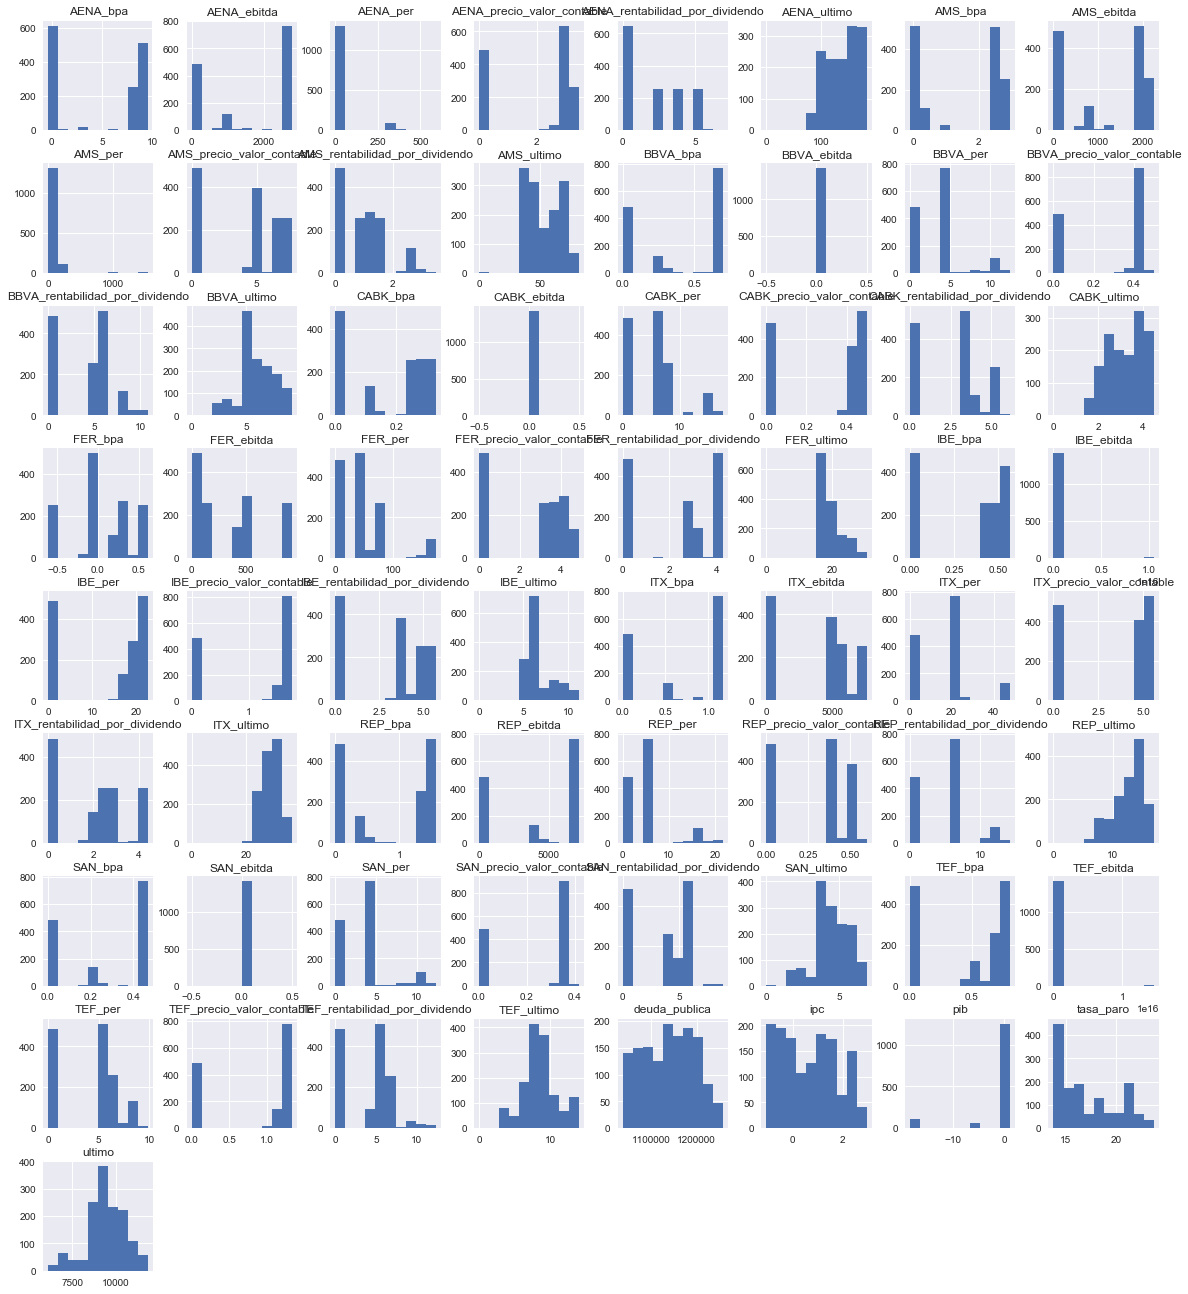

In [8]:
#data.hist(ax=ax)
#plt.show()
fig, ax = plt.subplots(figsize=(20,23))
data.hist(ax=ax)
plt.show()

Y pintamos la matriz de correlación:

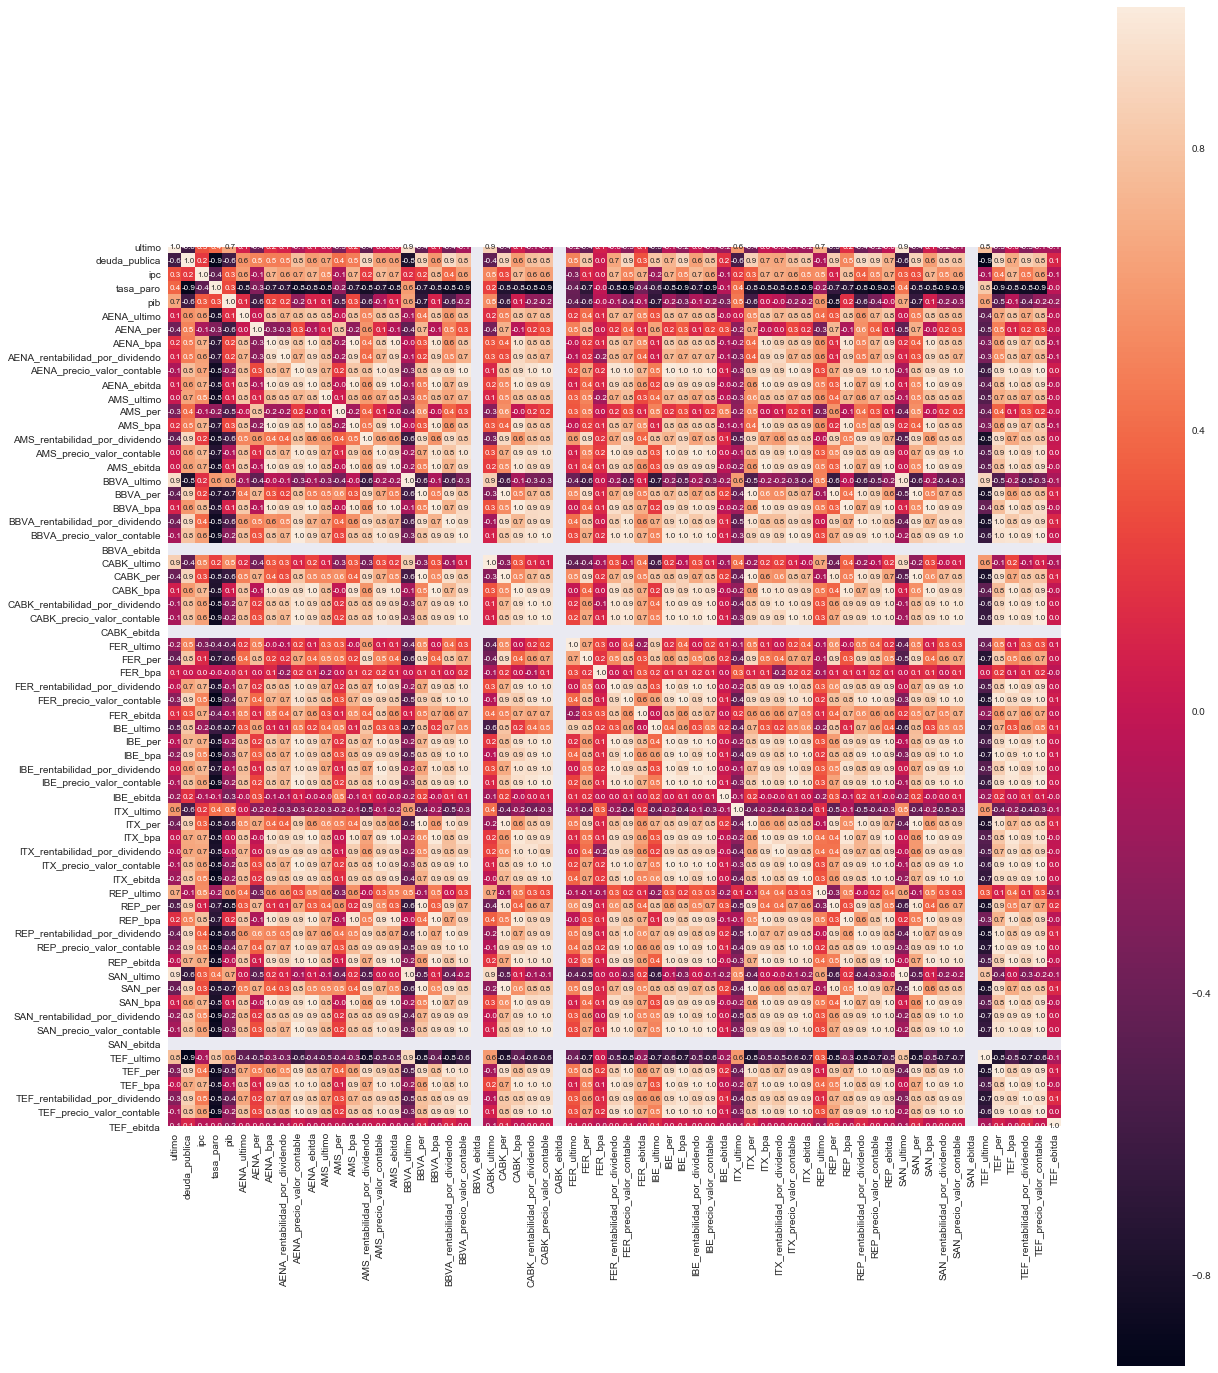

In [9]:
# Mostramos el diagrama de correlación entre los distintos predictores utilizando Seaborn > heatmap
corr_data = np.corrcoef(data.values.T)
columns = data.columns.values.tolist()
#sns.set(font_scale=1.3)
plt.subplots(figsize=(20,25))
heatmap_data = sns.heatmap(corr_data,
                          cbar=True,
                          annot=True,
                          square=True,
                          fmt='.1f',
                          annot_kws={'size':8},
                          yticklabels=columns,
                          xticklabels=columns)
plt.show()

Esta información es crítica a la hora de identificar cuáles pueden ser los mejores predictores para el modelo, qué variables presentan relaciones de tipo no lineal y para identificar colinialidad entre predictores.
De este análisis se pueden extraer las siguientes conclusiones:
- las variables que presentan bastante relación lineal positiva con ultimo son: pib (r=0.7), BBVA_ultimo (r=0.9), CABK_ultimo (r=0.9), ITX_ultimo (r=0.6), REP_ultimo (r=0.7), SAN_ultimo (r=0.9), TEF_ultimo (r=0.5)
- las variables que presentan bastante relación lineal negativa con ultimo son: deuda_publica (r=-0.6), IBE_ultimo (r=-0.5), REP_per (r=-0.5)
- también podemos observar que para los predictores CABK_ebitda, BBVA_ebitda y SAN_ebitda no existe información; todos los valores son 0.00 (se podrían quitar)

## Selección de los predictores y ajuste de un modelo support vector regression

Creamos trainig y test, donde test únicamente estará formado por 20 registros.

In [10]:
# Definimos las variables de entrada y salida
columns = data.columns.values.tolist()
columns.remove('ultimo')

X = data[columns]
y = data.ultimo
# Creamos los datasets de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20)
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (1403, 64) (1403,)
Testing dataset shape: (20, 64) (20,)


Utilizando la técnica GridSearchCV de Sklearn vamos a calcular cuales serían los mejores parámetros "gamma" y "C" utilizados en el modelo SVR() que minimicen el MSE.

In [11]:
cv_params = dict([
        ('gamma', 10.0**np.arange(-4,6)),
        ('C', 10.0**np.arange(-2,4)),
    ])
model = GridSearchCV(SVR(kernel = 'rbf'), cv_params, cv=5, verbose=1, n_jobs=-1, scoring="neg_mean_squared_error")
model.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(model.best_params_)
print("Grid scores on development set:")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.5s finished


Best parameters set found on development set:
{'C': 1000.0, 'gamma': 0.01}
Grid scores on development set:
-1186801.247 (+/-195165.848) for {'C': 0.01, 'gamma': 0.0001}
-1186813.149 (+/-195166.744) for {'C': 0.01, 'gamma': 0.001}
-1186852.872 (+/-195170.263) for {'C': 0.01, 'gamma': 0.01}
-1186942.465 (+/-195178.716) for {'C': 0.01, 'gamma': 0.1}
-1187009.358 (+/-195183.643) for {'C': 0.01, 'gamma': 1.0}
-1187022.644 (+/-195185.077) for {'C': 0.01, 'gamma': 10.0}
-1187023.147 (+/-195185.111) for {'C': 0.01, 'gamma': 100.0}
-1187023.149 (+/-195185.113) for {'C': 0.01, 'gamma': 1000.0}
-1187023.149 (+/-195185.113) for {'C': 0.01, 'gamma': 10000.0}
-1187023.149 (+/-195185.113) for {'C': 0.01, 'gamma': 100000.0}
-1184835.303 (+/-194990.972) for {'C': 0.1, 'gamma': 0.0001}
-1184954.233 (+/-195000.207) for {'C': 0.1, 'gamma': 0.001}
-1185351.373 (+/-195038.088) for {'C': 0.1, 'gamma': 0.01}
-1186236.309 (+/-195129.749) for {'C': 0.1, 'gamma': 0.1}
-1186883.690 (+/-195169.984) for {'C': 0.1, 

Según el análisis anterior los mejores parámetros para entrenar nuestro modelo son: {'C': 1000.0, 'gamma': 0.01}

Se va a implementar el modelo utilizando sklearn y todos los predictores:

In [13]:
# Definimos el algoritmo a utilizar
model01_svr = SVR(kernel = 'rbf', C=1000.0, gamma=0.01)
model01_svr.fit(X_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Aplicamos la técnica de Cross Validation sobre los datos de train.

In [14]:
# Cross validation
from sklearn.model_selection import cross_val_score

# Cross Validation
scores = cross_val_score(model01_svr,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

print("Métricas cros_validation:", scores)
print("Train > MSE cross_validation: ", scores.mean())

Métricas cros_validation: [ -72983.72368079  -46945.8441885   -27564.41329735 -155696.973538
  -63611.7568687 ]
Train > MSE cross_validation:  -73360.54231466765


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [21]:
path_model_save = "./models/svr_fit_ultimo_filter_data_deuda_publica+ipc+other_components.pkl"  
joblib.dump(model01_svr, path_model_save)

['./models/svr_fit_ultimo_filter_data_deuda_publica+ipc+other_components.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [16]:
model01_svr = joblib.load(path_model_save)

Finalmente realizamos las prediciones sobre los datos de test y obtenemos distintos estadísticos para comprobar como de eficiente es nuestro modelo.

In [17]:
y_pred = model01_svr.predict(X_test)

In [18]:
# MAE: Mean absolute error
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
# MSE: Mean squared error
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))
# RMSE: Root mean squared error
print("Root mean squared error: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# Coeficiente de variación. El mejor puntaje es un 1.0
print("R-Cuadrado: %.2f" % metrics.r2_score(y_test, y_pred))
# Precisión del modelo
print("Precisión del modelo: ", model01_svr.score(X_test, y_pred))

Mean absolute error: 115.20
Mean squared error: 118924.09
Root mean squared error: 344.85
R-Cuadrado: 0.92
Precisión del modelo:  1.0


El valor Multiple R-squared (R2) indica que el modelo calculado explica el 92% de la variablidad presente en la variable respuesta (ultimo) a su promedio es explicado por el modelo de regresión ajustado. Podemos concluir que el modelo lineal es adecuado para describir la relación que existe entre esas variables independientes (deuda_publica e ipc). 

A continuación vamos a mostrar los valores reales frente a los predichos por el modelo:

In [19]:
test_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
test_vs_pred

,Actual,Predicted
1347,6686.1,6787.075842
326,8714.0,8762.244055
1259,9511.7,9564.065243
508,9406.4,9402.876935
225,9641.9,9637.019899
914,9208.7,9249.153457
604,10740.7,10749.061046
1316,6581.6,8095.882343
1046,9209.8,9211.506395
142,10042.4,10022.735276


Para comparar la variación entre ambos valores de una forma más rápida y visual vamos a plotear los valores:

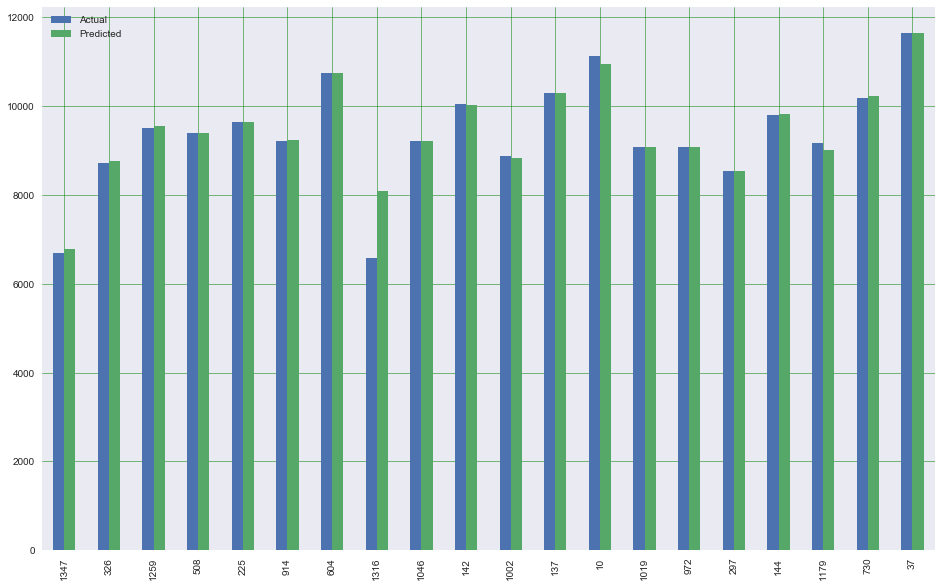

In [20]:
df1 = test_vs_pred.head(40)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Como podemos observar el modelo es aún bastante mejorable.